# PhageHostLearn - v2.3 (Klebsiella)

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

**Architecture of this framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Embeddings for both that are concatenated
- Train an XGBoost model on the concatenated embeddings (binary classification)

**Overview of the notebook**:

1. [Transform the loci proteins into embeddings](#locusembed)
2. [Transform the RBP sequences into embeddings](#rbpembed)
3. Constructing a dataframe for training models
4. [Concatenate and train an XGBoost and RF models](#models)

## 0 - Libraries and directories

In [1]:
import os
import math
import json
#import umap
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from Bio import SeqIO
from xgboost import XGBClassifier
from scipy.stats import spearmanr
from Bio.Blast import NCBIWWW, NCBIXML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from Bio.Blast.Applications import NcbiblastpCommandline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, LeaveOneGroupOut
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, auc, precision_recall_curve
#from bio_embeddings.embed import Word2VecEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder
%matplotlib inline

In [2]:
# set project directory (to locate Kaptive), data directory and results directory
project_dir = '/Users/dimi/Documents/GitHub_Local/PhageHostLearning'
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data' # general directory
data_suffix = 'Valencia' # choose a suffix for the created data files
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'

## 1 - Transform locus into embeddings<a name="locusembed"></a>

In [3]:
def loci_protein_embeddings(dict_path, results_dir):
    """
    This function computes ProtTransBertBFD embeddings for loci proteins in a dictionary (as json). It uses 
    the bio-embeddings package together with BioPython.
    
    WARNING: running this on a personal laptop without GPU can be slow (not advised). Best to start a Google
    Colab notebook and run the computations in the cloud.
    
    Input:
    - jason_dict: path to dictionary (json file) containing the accessions as keys and proteins as values
    - results_dir: path to dir to store embeddings
    Output:
    - an embeddings file with 1 resulting embedding per accession (= multi-instance)
    """
    
    # Load json file
    dict_file = open(dict_path)
    loci_dict = json.load(dict_file)
    
    # compute embeddings
    embedder = ProtTransBertBFDEmbedder()
    embeddings_list = [] # store locus embeddings
    for key in tqdm(loci_dict.keys()):
        embeddings = [embedder.reduce_per_protein(embedder.embed(sequence)) for sequence in tqdm(loci_dict[key])]
        locus_emb_matrix = np.vstack(embeddings)
        locus_embedding = np.mean(locus_emb_matrix, axis=0)
        embeddings_list.append(locus_embedding)
        
    embeddings_df = pd.concat([pd.DataFrame({'accession':list(loci_dict.keys())}), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(results_dir+'/loci_embeddings.csv', index=False)
    
    return

In [4]:
#json_file = valencia_dir+'/LociBaseValencia.json'
#loci_protein_embeddings(json_file, '')

## 2 - Tranform RBP sequences into embeddings <a name="rbpembed"></a>

In [ ]:
def RBP_embeddings(RBPbase, results_dir):
    """
    This function computes embeddings for RBPs in a pandas dataframe.
    """
    embedder = ProtTransBertBFDEmbedder()
    embeddings = [embedder.reduce_per_protein(embedder.embed(sequence)) for sequence in tqdm(RBPbase['protein_sequence'])]
    embeddings_df = pd.concat([pd.DataFrame({'protein_ID':list(RBPbase['protein_ID'])}), pd.DataFrame(embeddings)], axis=1)
    embeddings_df.to_csv(results_dir+'/RBP_embeddings.csv', index=False)
    return

In [65]:
#RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')
#RBP_embeddings(RBPbase, results_dir) # do in Google Colab or Kaggle

Alternatively, we can subselect previously computed embeddings (for RBP detection step)

In [18]:
phage_protein_embeddings = pd.read_csv(valencia_dir+'/phage_proteinsValencia_embeddings.csv')
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')

to_delete = []
for i, protein_id in enumerate(phage_protein_embeddings['ID']):
    if protein_id not in list(RBPbase['protein_ID']):
        to_delete.append(i)
        
RBP_embeddings = phage_protein_embeddings.drop(to_delete)
RBP_embeddings = RBP_embeddings.reset_index(drop=True)
RBP_embeddings = pd.concat([RBPbase['phage_ID'], RBP_embeddings], axis=1)
RBP_embeddings.to_csv(valencia_dir+'/RBP_embeddings.csv', index=False)

## 3 - Processing into structured dataframe for training at multi-RBP level

In [3]:
# construct multi-RBP representations
RBP_embeddings = pd.read_csv(valencia_dir+'/esm2_embeddings_rbpValencia.csv')

multi_embeddings = []
names = []
for phage_id in list(set(RBP_embeddings['phage_ID'])):
    rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
    multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
    names.append(phage_id)
    multi_embeddings.append(multi_embedding)
multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

In [5]:
# construct dataframe for training
loci_embeddings = pd.read_csv(valencia_dir+'/esm2_embeddings_lociValencia.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)
features = []
labels = []
groups_loci = []
groups_phage = []
for i, accession in enumerate(loci_embeddings['accession']):
    for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
        interaction = interactions.loc[accession][phage_id]
        if math.isnan(interaction) == False: # if the interaction is known
            features.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
            labels.append(int(interaction))
            groups_loci.append(i)
            groups_phage.append(j)
features = np.asarray(features)
print("Dimensions match?", features.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))

Dimensions match? True


## 4 - Building and evaluating machine learning models <a name="models"></a>

Idea is to (1) shuffle data, (2) keep a test set aside, (3) do CV for hyperparameter tuning, (4) plot learning curves with optimized hyperparams and (5) test final performance on test set.

#### XGBoost

In [6]:
# shuffle and set test set aside
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)

In [7]:
# define model and cross-validation iterator
cpus = 6
imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])
xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=cpus, use_label_encoder=False)
params_xgb = {'max_depth': [3, 5, 7], 'n_estimators': [250, 500, 750], 
              'learning_rate': [0.2, 0.3]}
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [8]:
# do hyperparameter tuning (in GridSearchCV)
tuned_xgb = GridSearchCV(xgb, cv=cv, param_grid=params_xgb, scoring='roc_auc', verbose=3)
tuned_xgb.fit(X_train, y_train, eval_metric='logloss')
print(tuned_xgb.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=250;, score=0.748 total time=  15.9s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=250;, score=0.882 total time=  15.9s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=250;, score=0.842 total time=  18.2s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=250;, score=0.776 total time=  18.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=250;, score=0.894 total time=  18.5s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=500;, score=0.755 total time=  37.2s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=500;, score=0.882 total time=  38.2s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=500;, score=0.856 total time=  38.9s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=500;, score=0.768 total time=  39.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=500;, score=0.906 total ti

[CV 2/5] END learning_rate=0.3, max_depth=7, n_estimators=750;, score=0.873 total time= 2.0min
[CV 3/5] END learning_rate=0.3, max_depth=7, n_estimators=750;, score=0.826 total time= 2.1min
[CV 4/5] END learning_rate=0.3, max_depth=7, n_estimators=750;, score=0.786 total time= 2.0min
[CV 5/5] END learning_rate=0.3, max_depth=7, n_estimators=750;, score=0.912 total time= 2.1min
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 250}


In [9]:
# test set evaluation
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=5,
                    n_jobs=cpus, use_label_encoder=False)
xgb.fit(X_train, y_train)
score_xgb = xgb.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_test, score_xgb))

[11:57:58] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.8329878134192463


In [10]:
results = pd.DataFrame({'labels': y_test, 'scores': score_xgb})
results.to_csv(results_dir+'/v3.3/language_xgb_kfoldscores.csv', index=False)

The fact that we're seeing a higher AUC on the test set then before with the learning curve to me indicates that sufficient data is crucial! In the learning curve, we splitted X_train up into train an validation, and result is lower AUC... so enough data seems crucial!

#### Randomized labels

In [17]:
random.shuffle(y_train)
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=500, max_depth=5,
                    n_jobs=cpus, use_label_encoder=False)
xgb.fit(X_train, y_train)
score_xgb = xgb.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_test, score_xgb))
results = pd.DataFrame({'labels': y_test, 'scores': score_xgb})
results.to_csv(results_dir+'/v2.2/language_xgb_scores_random.csv', index=False)

[11:21:38] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.5167767890216484


#### LOGOCV XGBoost over loci

Basically, the idea is to do a LOGOCV with every locus being one group (so a total of ~200 groups). We won't do hyperparam optimization, as that would be too computationally intensive, but we will assume standard params except for the 500 estimators. Then, we can also compute MRR, because we know that each test set is in fact one query for which the probabilities can be ranked.

In [20]:
seros = pd.read_csv(valencia_dir+'/serotypes'+data_suffix+'.csv')

In [21]:
def mean_reciprocal_rank(queries):
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    queries = (np.asarray(r).nonzero()[0] for r in queries)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in queries])

In [22]:
def recallatk(queries, k):
    """
    recall at top K for binary problems. Relevant items should be labeled as 1.
    
    Input: 
    - queries: list of lists of queries that are sorted (i.e. true labels sorted by prediction score)
    - k: the top you want to look at
    """
    recalls_k = [query[:k].count(1) / query.count(1) for query in queries]
    return np.mean(recalls_k)

In [23]:
def hitratio(queries, k):
    """
    hit ratio for in the first k elements (sorted queries)
    """
    return sum([1 for query in queries if sum(query[:k]) > 0]) / len(queries)

In [27]:
# do the LOGOCV
logo = LeaveOneGroupOut()
cpus = 6
rocauc_scores = []
prauc_scores = []
noauc_scores = []
ranked_queries = []
labels = np.asarray(labels)
sero_groups = []
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features, labels, groups_loci):
    # get the training and test data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])

    # fit a XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(X_train, y_train)
    
    # make predictions & compute ROC + PR AUC
    score_xgb = xgb.predict_proba(X_test)[:,1]
    try:
        roc_auc = roc_auc_score(y_test, score_xgb)
        rocauc_scores.append(roc_auc)
        precision, recall, thresholds = precision_recall_curve(y_test, score_xgb)
        pr_auc = round(auc(recall, precision), 3)
        prauc_scores.append(pr_auc)
        this_sero = seros['sero'][groups_loci[test_index[0]]]
        sero_groups.append(this_sero) # get serotype linked to this test group
        # sort labels to compute MRR later
        ranked_query = [x for _, x in sorted(zip(score_xgb, y_test), reverse=True)]
        ranked_queries.append(ranked_query)
    except:
        noauc_scores.append(score_xgb)
  
    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
# print results
print('ROC AUC: ', np.mean(rocauc_scores))
print('PR AUC: ', np.mean(prauc_scores))
print('MRR: ', mean_reciprocal_rank(ranked_queries))
print('top 10 Recall: ', recallatk(ranked_queries, 10))
logo_results = pd.DataFrame({'sero': sero_groups, 'rocauc_scores': rocauc_scores, 'prauc_scores': prauc_scores, 
                             'ranked_queries': ranked_queries})
logo_results.to_csv(results_dir+'/v2.3/language_xgb_logocv_results.csv', index=False)

ROC AUC:  0.8136089389782957
PR AUC:  0.5655905511811024
MRR:  0.6850350571119078
top 10 Recall:  0.6821772278465192


In [29]:
ks = np.linspace(1, 50, 50)
recalls = [recallatk(logo_results['ranked_queries'], int(k)) for k in ks]

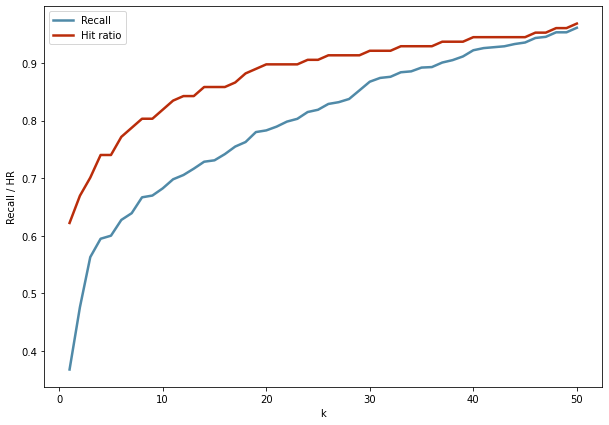

In [30]:
logo_results = pd.read_csv(results_dir+'/v2.3/language_xgb_logocv_results.csv', converters={'ranked_queries': pd.eval})
ks = np.linspace(1, 50, 50)
recalls = [recallatk(logo_results['ranked_queries'], int(k)) for k in ks]
hits = [hitratio(logo_results['ranked_queries'], int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(ks, recalls, c='#508AA8', linewidth=2.5, label='Recall')
ax.plot(ks, hits, c='#BA2D0B', linewidth=2.5, label='Hit ratio')
ax.set_xlabel('k')
ax.set_ylabel('Recall / HR')
ax.legend()
fig.savefig(results_dir+'/v2.3/language_xgb_logocv_recall_hitratio.png', dpi=400)

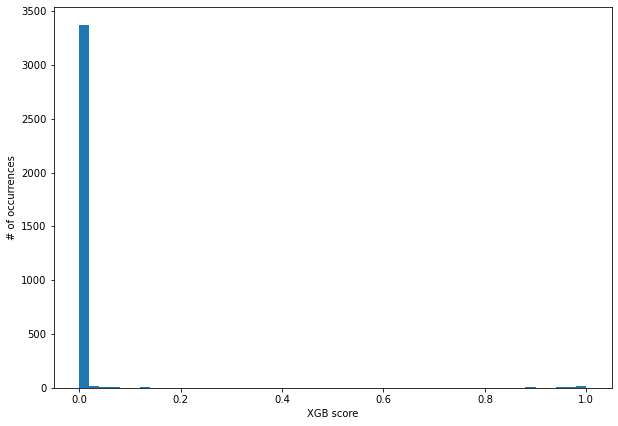

In [31]:
noauc_flat = np.concatenate(noauc_scores).ravel()
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(noauc_flat, bins=50)
ax.set_xlabel('XGB score')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/v2.3/language_xgb_logocv_noauc_scores.png', dpi=400)

#### Single-RBP LOOCV

In [37]:
logo = LeaveOneGroupOut()
cpus = 6
rocauc_scores = []
prauc_scores = []
noauc_scores = []
ranked_queries = []
labels = np.asarray(labels)
sero_groups = []
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features, labels, groups_loci):
    # get the training and test data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    phage_test = np.asarray(groups_phage)[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])

    # fit a XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(X_train, y_train)
    
    # loop over phage's RBPs
    score_xgb = []
    loci_embedding = X_test[0, :1280] # always the same within a test group
    for phage_index in phage_test:
        # get the correct embeddings
        phage_id = list(multiRBP_embeddings['phage_ID'])[phage_index]
        rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
        
        # make predictions for each single RBP
        rbp_scores = []
        for rbpi in range(rbp_embeddings.shape[0]):
            test_embedding = pd.concat([pd.DataFrame(loci_embedding), rbp_embeddings.iloc[rbpi,:]])
            this_xgb_score = xgb.predict_proba(np.asarray(test_embedding).reshape((1,-1)))[:,1]
            rbp_scores.append(this_xgb_score[0])
                              
        # add max score to the list for AUC computing
        score_xgb.append(max(rbp_scores))
    
    # compute ROC & PR AUC
    try:
        roc_auc = roc_auc_score(y_test, score_xgb)
        rocauc_scores.append(roc_auc)
        precision, recall, thresholds = precision_recall_curve(y_test, score_xgb)
        pr_auc = round(auc(recall, precision), 3)
        prauc_scores.append(pr_auc)
        this_sero = seros['sero'][groups_loci[test_index[0]]]
        sero_groups.append(this_sero) # get serotype linked to this test group

        # sort labels to compute MRR later
        ranked_query = [x for _, x in sorted(zip(score_xgb, y_test), reverse=True)]
        ranked_queries.append(ranked_query) 
    except:
        noauc_scores.append(score_xgb)

    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [38]:
# print results
print('ROC AUC: ', np.mean(rocauc_scores))
print('PR AUC: ', np.mean(prauc_scores))
print('MRR: ', mean_reciprocal_rank(ranked_queries))
print('top 10 recall: ', recallatk(ranked_queries, 10))
logo_results = pd.DataFrame({'sero': sero_groups, 'rocauc_scores': rocauc_scores, 'prauc_scores': prauc_scores, 
                             'ranked_queries': ranked_queries})
logo_results.to_csv(results_dir+'/v2.3/language_xgb_singlerbp_logocv_results.csv', index=False)

ROC AUC:  0.7785468959224573
PR AUC:  0.3663464566929134
MRR:  0.47427649711853287
top 10 recall:  0.6006061742282215


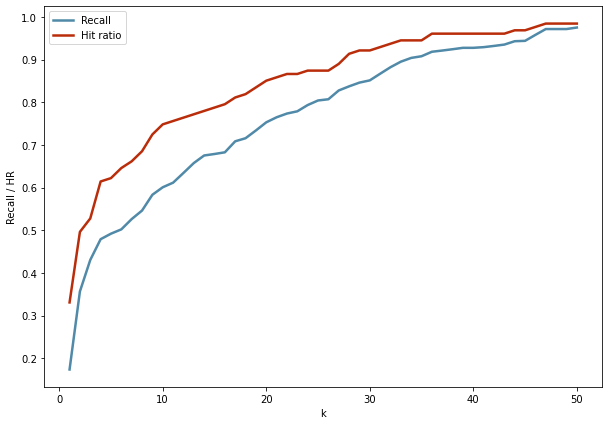

In [39]:
logo_results = pd.read_csv(results_dir+'/v2.3/language_xgb_singlerbp_logocv_results.csv', converters={'ranked_queries': pd.eval})
ks = np.linspace(1, 50, 50)
recalls = [recallatk(logo_results['ranked_queries'], int(k)) for k in ks]
hits = [hitratio(logo_results['ranked_queries'], int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(ks, recalls, c='#508AA8', linewidth=2.5, label='Recall')
ax.plot(ks, hits, c='#BA2D0B', linewidth=2.5, label='Hit ratio')
ax.set_xlabel('k')
ax.set_ylabel('Recall / HR')
ax.legend()
fig.savefig(results_dir+'/v2.3/language_xgb_singlerbp_logocv_recall_hitratio.png', dpi=400)

In [ ]:
noauc_flat = np.concatenate(noauc_scores).ravel()
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(noauc_flat, bins=50)
ax.set_xlabel('XGB score')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/v2.3/language_xgb_singlerbp_logocv_noauc_scores.png', dpi=400)

#### Randomized labels LOGOCV

In [8]:
# do the LOGOCV
logo = LeaveOneGroupOut()
cpus = 6
rocauc_scores = []
prauc_scores = []
noauc_scores = []
ranked_queries = []
labels = np.asarray(labels)
sero_groups = []
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features, labels, groups_loci):
    # get the training and test data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])
    random.shuffle(y_train)

    # fit a XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_estimators=500, n_jobs=cpus, eval_metric='logloss', 
                        use_label_encoder=False)
    xgb.fit(X_train, y_train)
    
    # make predictions & compute ROC + PR AUC
    score_xgb = xgb.predict_proba(X_test)[:,1]
    try:
        roc_auc = roc_auc_score(y_test, score_xgb)
        rocauc_scores.append(roc_auc)
        precision, recall, thresholds = precision_recall_curve(y_test, score_xgb)
        pr_auc = round(auc(recall, precision), 3)
        prauc_scores.append(pr_auc)
        this_sero = seros['sero'][groups_loci[test_index[0]]]
        sero_groups.append(this_sero) # get serotype linked to this test group
        # sort labels to compute MRR later
        ranked_query = [x for _, x in sorted(zip(score_xgb, y_test), reverse=True)]
        ranked_queries.append(ranked_query)
    except:
        noauc_scores.append(score_xgb)
  
    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# print results
print('ROC AUC: ', np.mean(rocauc_scores))
print('PR AUC: ', np.mean(prauc_scores))
print('MRR: ', mean_reciprocal_rank(ranked_queries))
print('top 10 recall: ', recallatk(ranked_queries, 10))

ROC AUC:  0.49176550418033227
PR AUC:  0.08181102362204723
MRR:  0.16767793879172216
top 10 recall:  0.1955693038370204


## X - Out of use